# HW3: Feature Matching and Binary Images



In this homework assignment, we will see how to use binary images and their utility, and how to match features between images

In [36]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import requests
import skimage.io

%matplotlib inline

## Feature Matching

Load the exercise images:

In [37]:
im1 = cv2.imdecode(np.frombuffer(requests.get("https://drive.google.com/uc?id=1y8eKxsxxQDDxnwZex_qNi_1QtEmr7xai").content, np.uint8), cv2.IMREAD_GRAYSCALE)
im2 = cv2.imdecode(np.frombuffer(requests.get("https://drive.google.com/uc?id=1ZRNAyo9SUeL0BcTJKFzKuEku2-YTkvA9").content, np.uint8), cv2.IMREAD_GRAYSCALE)
im3 = cv2.imdecode(np.frombuffer(requests.get("https://drive.google.com/uc?id=1DPGLB1NtZiPEhSVHnVq_1yc5d5XSCEjf").content, np.uint8), cv2.IMREAD_GRAYSCALE)

Make sure the download worked

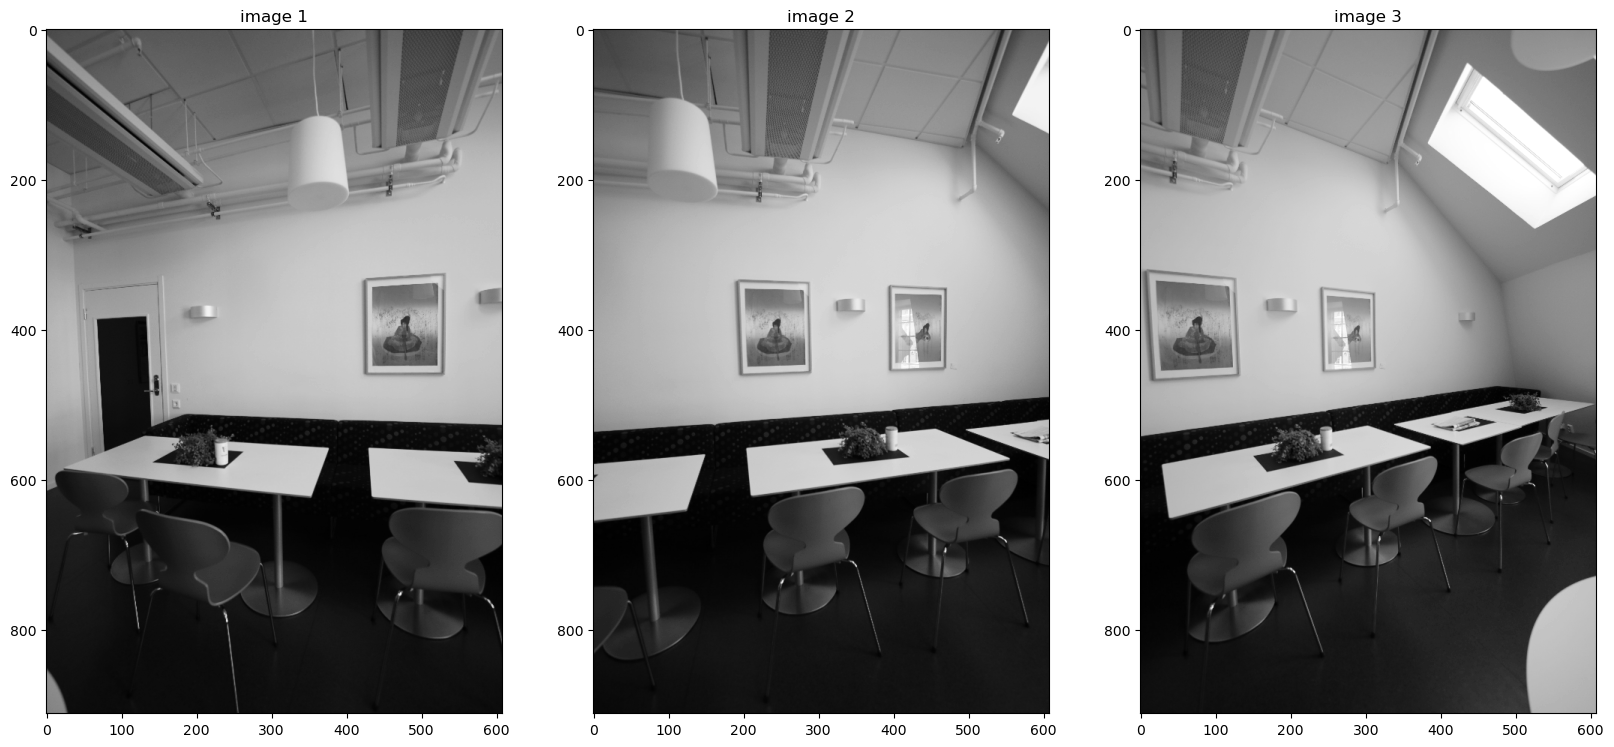

In [38]:
plt.figure(figsize=(20,10))
plt.subplot(131),plt.imshow(im1, cmap='gray'),plt.title('image 1')
plt.subplot(132),plt.imshow(im2, cmap='gray'),plt.title('image 2')
plt.subplot(133),plt.imshow(im3, cmap='gray'),plt.title('image 3');

Use image 1 and image 2

Extract SIFT keypoints and descriptors from both images (`cv2.xfeatures2d.SIFT_create()` and `.detectAndCompute()`).

Match the descriptors (2-nn) and apply the ratio test (`cv2.BFMatcher_create` and `.knnMatch()`)

Show the matching before and after the ratio test (`cv2.drawMatchesKnn`)

In [39]:
# TODO: your code here

# extract SIFT features from the images im1 and im2
# hint:
# sift = cv2.SIFT_create()
# kpts1,desc1 = sift.detectAndCompute(...)
# kpts2,desc2 = sift.detectAndCompute(...)
sift = cv2.SIFT_create()
kpts1,desc1 = sift.detectAndCompute(im1, None)
kpts2,desc2 = sift.detectAndCompute(im2, None)

# match features using Brute Force matcher, e.g. cv2.BFMatcher_create() and cv2.BFMatcher.knnMatch()
bf = cv2.BFMatcher_create()
matches = cv2.BFMatcher.knnMatch(bf, desc1, desc2, k=2)

# Apply ratio test with 0.75 difference factor
good = []
# TODO: your code here
for m,n in matches:
    # check if the distance between the two matches is less than 0.75 times the distance of the best match
    # if so, append the match to the "good" list
    # hint: use m.distance and n.distance
    if m.distance < 0.75 * n.distance:
        good.append([m])

# for future use in the next question, align the "good" points in two arrays
# TODO: your code here
# hint: use np.array([[0,0]]*len(good)), this will create an array of zeros with the same length as the "good" list
# you will need two arrays, one for the points in image 1 (e.g. pts1) and one for the points in image 2 (e.g. pts2)
# then, for each match in the "good" list, use the .queryIdx and .trainIdx to get the corresponding points
# and append them to the corresponding array, e.g. pts1[i] = kpts1[match[0].queryIdx].pt
# use enumerate(good) to get the index i and the match in each iteration
# use .pt to get the actual point, and use i to put the point in the correct index in the pts1 and pts2 array
pts1,pts2 = np.array([[0,0]]*len(good)), np.array([[0,0]]*len(good))
for i, match in enumerate(good):
    pts1[i] = kpts1[match[0].queryIdx].pt
    pts2[i] = kpts2[match[0].trainIdx].pt  

This is how it should look like:

(<Axes: title={'center': 'ratio test'}>,
 Text(0.5, 1.0, 'ratio test'))

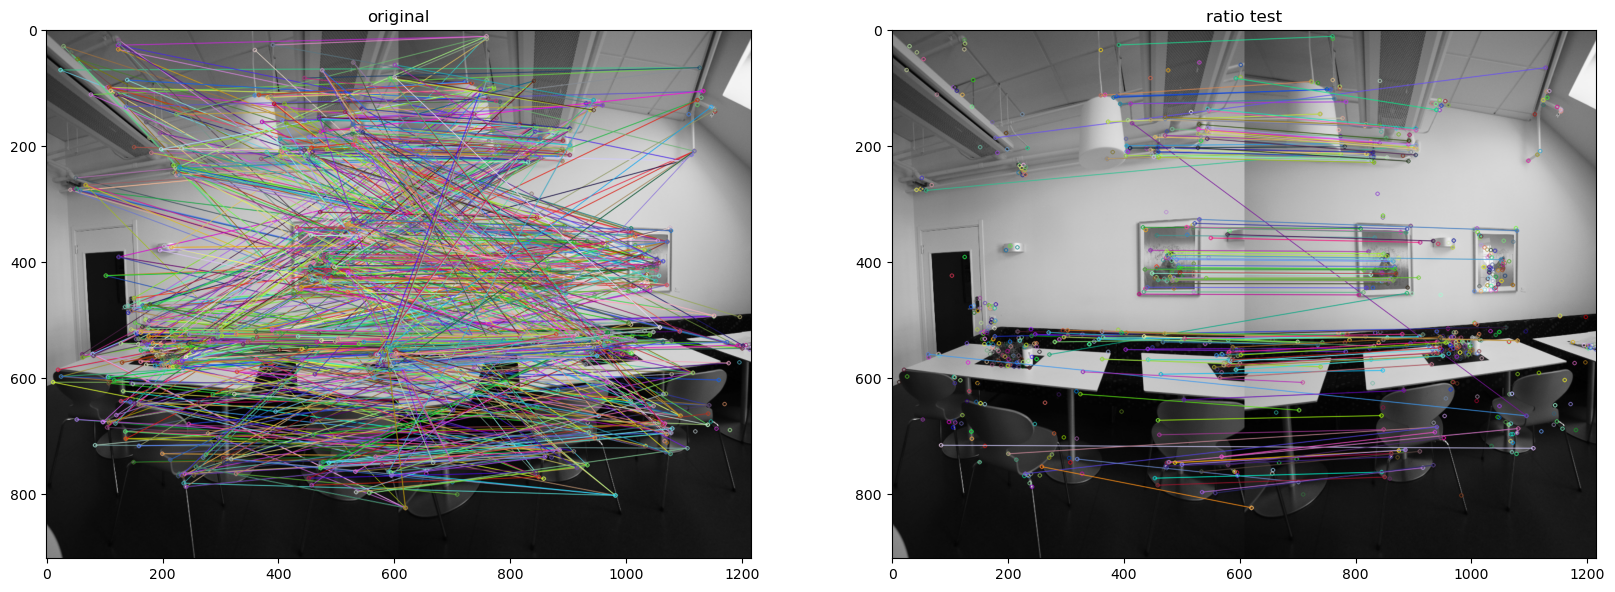

In [40]:
plt.figure(figsize=(20,10))
plt.subplot(121),plt.imshow(cv2.drawMatchesKnn(im1,kpts1,im2,kpts2,matches,im1.copy())), plt.title('original')
plt.subplot(122),plt.imshow(cv2.drawMatchesKnn(im1,kpts1,im2,kpts2,good,im1.copy())), plt.title('ratio test')

In [41]:
# apply the reciprocity test to the "good" matches to remove outliers (see lecture slides)
# TODO: your code here
# for reciprocity, we need to test the matches from desc2 to desc1 using bf.knnMatch(desc2, desc1, 2)
# then, for each match in the "good" list, we need to check if the match from desc2 to desc1 is also in the "good" list
# if so, append the match to the "good_reciprocal" list
# hint: use the .queryIdx and .trainIdx to get the corresponding points
# use enumerate(good) to get the index i and the match in each iteration
# use .pt to get the actual point, and use i to put the point in the correct index in the pts1 and pts2 array
good_reciprocal = []
matches2 = cv2.BFMatcher.knnMatch(bf, desc2, desc1, k=2) # use bf.knnMatch to go to desc2 to desc1 this time
for i, good_match in enumerate(good):
    # good_match is a match from desc1 to desc2,
    # a reciprocal match would be a match from desc2 to desc1
    # so we need to check in the reciprocal matches (matches2) if there is a match from desc2 to desc1
    for reciprocal_match, _ in matches2:
        # if the queryIdx of the `matches2`` is the same as the trainIdx of the `good` match
        # and the trainIdx of the `matches2` is the same as the queryIdx of the `good` match
        # then we have a reciprocal match
        if reciprocal_match.queryIdx == good_match[0].trainIdx and reciprocal_match.trainIdx == good_match[0].queryIdx:
            good_reciprocal.append(good_match)

# for future use in the next question, align the "good_reciprocal" points in two arrays
pts1,pts2 = np.array([[0,0]]*len(good_reciprocal)),np.array([[0,0]]*len(good_reciprocal))
for i, match in enumerate(good_reciprocal):
    pts1[i] = kpts1[match[0].queryIdx].pt
    pts2[i] = kpts2[match[0].trainIdx].pt

(<Axes: title={'center': 'reciprocal: 141 matches'}>,
 Text(0.5, 1.0, 'reciprocal: 141 matches'))

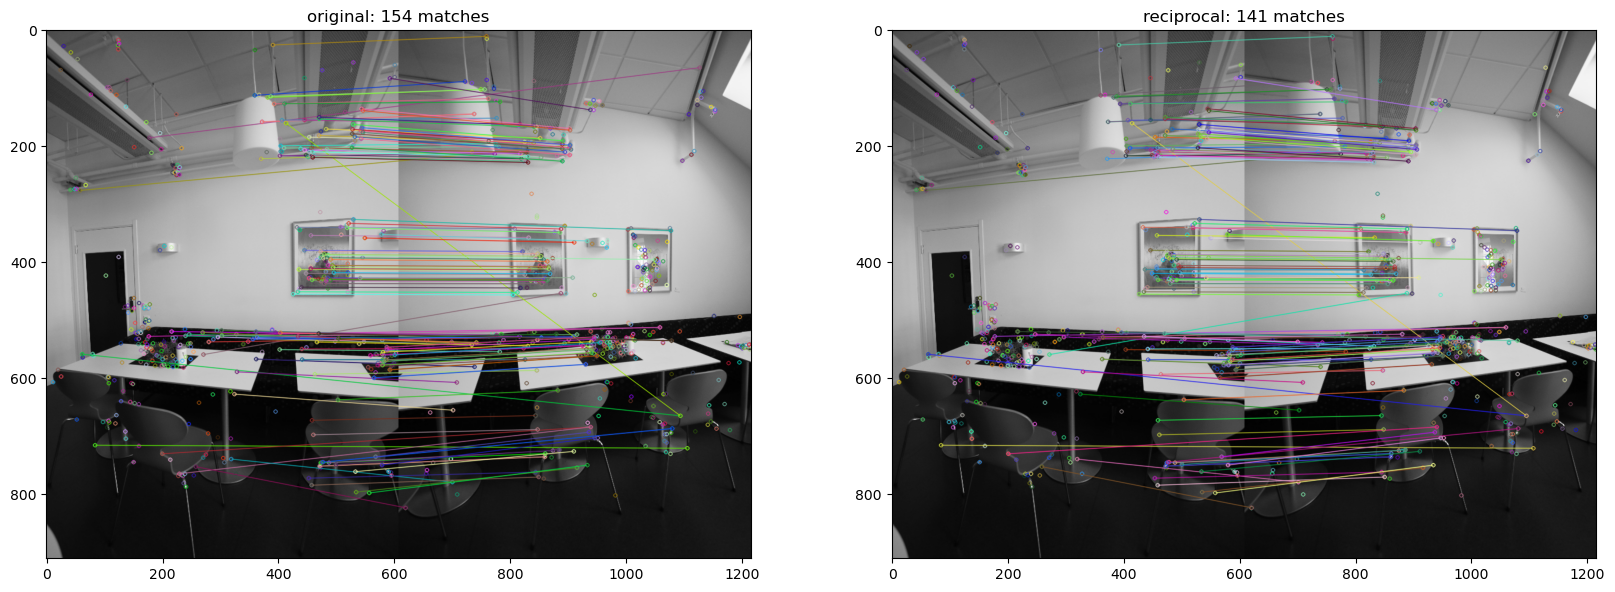

In [42]:
# show the matching results, use cv2.drawMatchesKnn to draw the matches in the good and good_reciprocal lists, side by side
plt.figure(figsize=(20,10))
plt.subplot(121),plt.imshow(cv2.drawMatchesKnn(im1,kpts1,im2,kpts2,good,im1.copy())), plt.title(f'original: {len(good)} matches')
plt.subplot(122),plt.imshow(cv2.drawMatchesKnn(im1,kpts1,im2,kpts2,good_reciprocal,im1.copy())), plt.title(f'reciprocal: {len(good_reciprocal)} matches')

We were able to get a little bit more specificity in our matching, which is always a good thing.

## Geometric Model Fitting

Given the above matching (make sure you keep the `good` variable!)


### Affine transform

Find an affine transform using Linear Least Squares by solving a $Ax=0$ equation (use `np.linalg.svd`) and show the resulting warping (`cv2.warpAffine`).

Let $p_i^{(1)}=(x_i^{(1)},y_i^{(1)})$ and $p_i^{(2)}=(x_i^{(2)},y_i^{(2)})$ be matching points in images 1 and 2 respectively, recall:

$$
Mp_i^{(1)} =
\begin{pmatrix}
a & b & t_x \\
c & d & t_y \\
\end{pmatrix}
\begin{pmatrix}
x_i^{(1)} \\ y_i^{(1)} \\ 1
\end{pmatrix}
\mathop{=}_{\mathrm{should}}
\begin{pmatrix}
x_i^{(2)} \\ y_i^{(2)} 
\end{pmatrix}
= p_i^{(2)}
$$

So we would like to minimize the following functor

$$
E_\mathrm{affine}(P_{n}^{(1)},P_{n}^{(2)}) = \sum_i^n || Mp_i^{(1)} - p_i^{(2)} ||
$$

In terms of $M$, e.g.
$$
\hat{M} = \arg\min_{M} E_\mathrm{affine}(P_{n}^{(1)},P_{n}^{(2)})
$$

Expand the multiplication:
$$
x_i^{(2)} = ax_i^{(1)} + by_i^{(1)} + t_x\\
y_i^{(2)} = cx_i^{(1)} + dy_i^{(1)} + t_y
$$

We construct a system of equations of shape $Ax=b$:
$$
\begin{pmatrix}
& \cdots & \\ 
x_i^{(1)} & y_i^{(1)} & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & x_i^{(1)} & y_i^{(1)} & 1 \\
& \cdots & 
\end{pmatrix}
\begin{pmatrix}
a \\ b \\ t_x \\ c \\ d \\ t_y
\end{pmatrix}
\mathop{=}_{\mathrm{should}}
\begin{pmatrix}
\cdots \\ x_i^{(2)} \\ y_i^{(2)} \\ \cdots 
\end{pmatrix}
$$

---

In [43]:
# linear least squares solution for finding an affine trasformation matrix
def findAffineLLSQ(ptsLeft, ptsRight):
    # create an empty A matrix, which is a 2n x 6 matrix, where n is the number of points
    A = np.repeat(np.array([[0]*6] * len(ptsLeft), np.float32), 2, axis=0)
    # create a b vector, which is a 2n x 1 vector (column vector) of zeros (np.zeros) with the same length as the A matrix rows (len(A))
    b = np.zeros((len(A),1), np.float32)
    for i in range(len(ptsLeft)):
        # TODO: your code, populate the A matrix
        # hint: use the ptsLeft and ptsRight arrays to get the points, and use the i index to put the points in the correct row
        # e.g. xL,yL = ptsLeft[i] will give you the left point, and xR,yR = ptsRight[i] will give you the right point

        xL,yL = ptsLeft[i]
        xR,yR = ptsRight[i] 

        # according to the guidance above, we need to populate the A matrix with the following two rows for each point:
        # [xL,yL,1,0,0,0]
        # [0,0,0,xL,yL,1]
        # the row index can be figured out using the i index
        A[i*2] = np.array([xL, yL, 1, 0, 0, 0])
        A[i*2+1] = np.array([0, 0, 0, xL, yL, 1])

        # populate the b vector with the following two rows for each point:
        # [xR]
        # [yR]
        # the row index can be figured out using the i index
        b[i*2] = xR
        b[i*2+1] = yR 

    # TODO: your code here...
    # use np.linalg.lstsq to solve the linear system of equations
    # hint: use np.linalg.lsqsq(A,b) (use recond=None to avoid warnings)
    # the result will be a 6x1 vector, which we need to reshape to a 2x3 matrix
    # hint: use np.reshape((2,3))
    # return the result
    return np.reshape(np.linalg.lstsq(A,b, rcond=None)[0], (2,3))

In [44]:
# a utility for warping and blending images using an affine transformation matrix
def warpAndblendImagesAffine(image1,image2,M):
    h_,w_ = image1.shape
    im2warp = cv2.warpAffine(image2, M, (w_,h_), flags=cv2.WARP_INVERSE_MAP, borderMode=cv2.BORDER_CONSTANT)
    im2mask = cv2.warpAffine(np.ones_like(image2), M, (w_,h_), flags=cv2.WARP_INVERSE_MAP, borderMode=cv2.BORDER_CONSTANT)
    return image1 * (1.0 - im2mask) + im2warp * im2mask

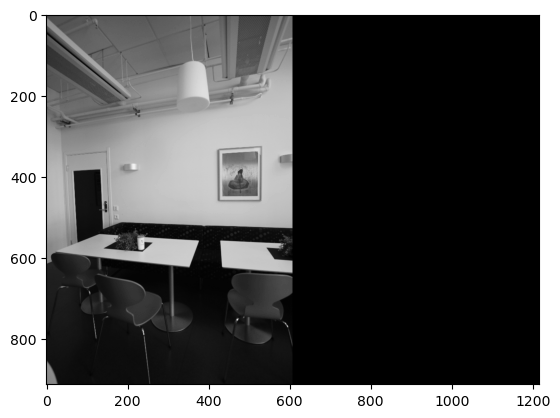

In [45]:
# make a copy of image 1 with room on the right for image 2
im1wide = np.hstack([im1, np.zeros_like(im1)])

# display the im1wide image
plt.imshow(im1wide, cmap='gray')

[[ 2.0012304e-01  9.9137738e-02  1.2282302e+02]
 [-3.6624204e-02  9.3272591e-01  4.7680122e+01]]


(<Axes: title={'center': 'aligned image 2'}>,
 Text(0.5, 1.0, 'aligned image 2'))

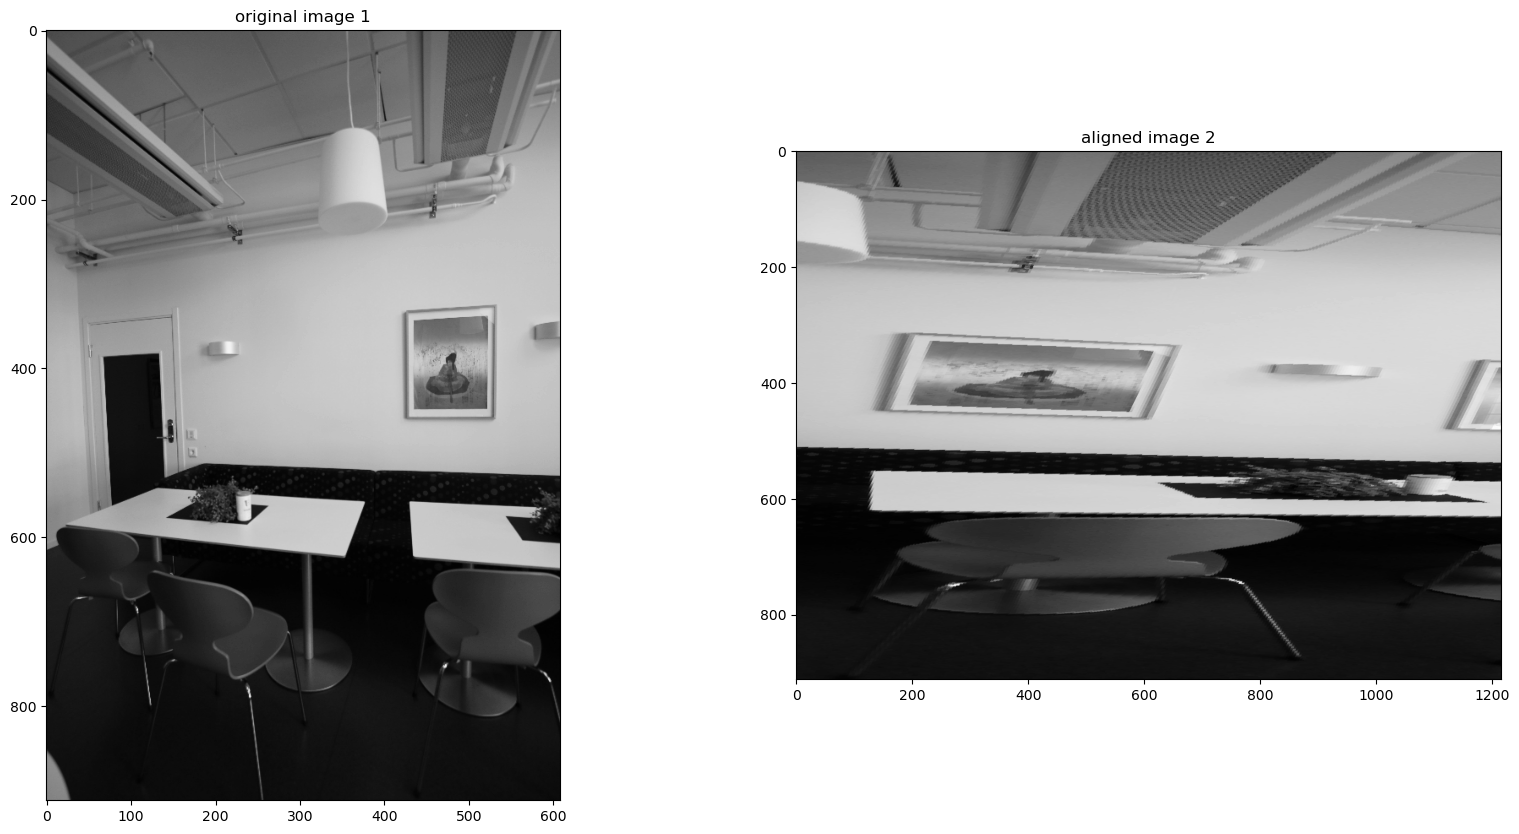

In [46]:
# use the findAffineLLSQ function you wrote to find the affine transformation matrix between the two images
# using the pts1 and pts2 arrays
M = findAffineLLSQ(pts1, pts2)
print(M)

# show the result using warpAndBlendImagesAffine side by side with the original image
plt.figure(figsize=(20,10))
plt.subplot(121),plt.imshow(im1, cmap='gray'), plt.title('original image 1')
plt.subplot(122),plt.imshow(warpAndblendImagesAffine(im1wide, im2, M), cmap='gray'), plt.title('aligned image 2')

This is looking pretty bad. Not even close!

Let's try OpenCV's method that can apply the RANSAC method for eliminating outliers

In [47]:
# use cv2.estimateAffine2D to find the affine transformation matrix using the pts1 and pts2 arrays
# RANSAC will be the default method
M, mask = cv2.estimateAffine2D(pts1, pts2)

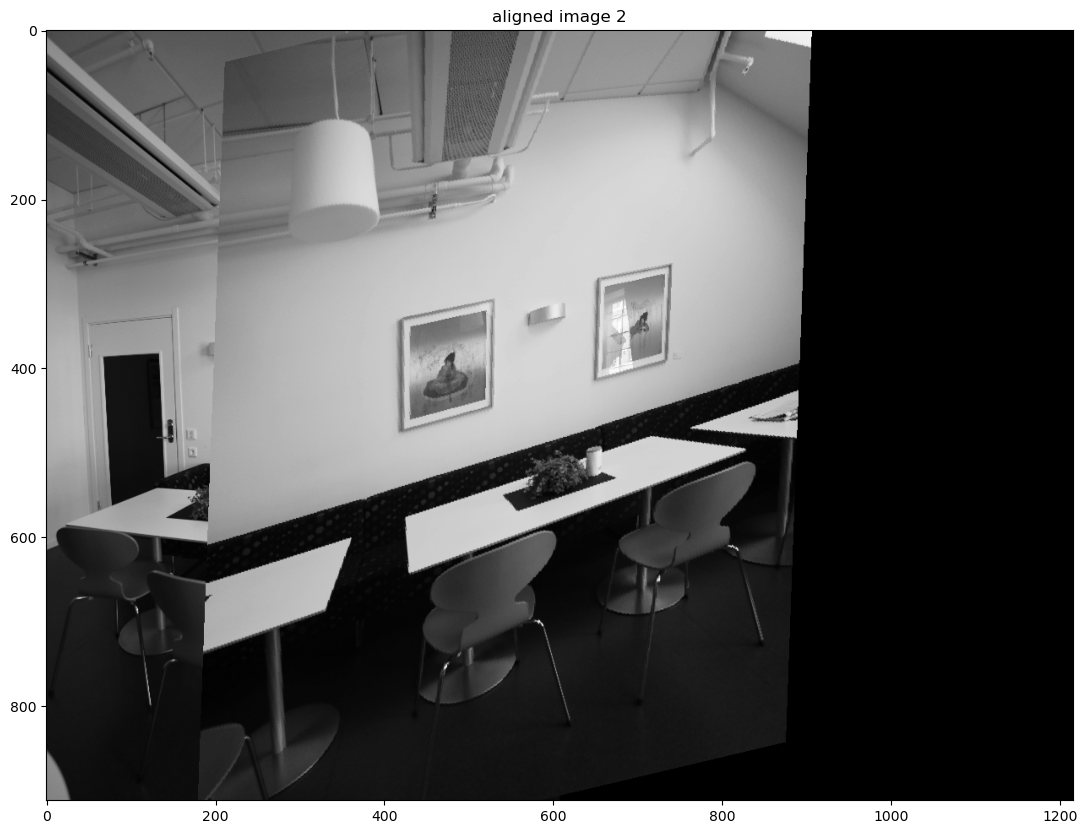

In [48]:
plt.figure(figsize=(20,10))
plt.imshow(warpAndblendImagesAffine(im1wide, im2, M), cmap='gray'), plt.title('aligned image 2');

Eeef . Still pretty bad. 

Let's look at which point-pairs have survived the affine RANSAC:

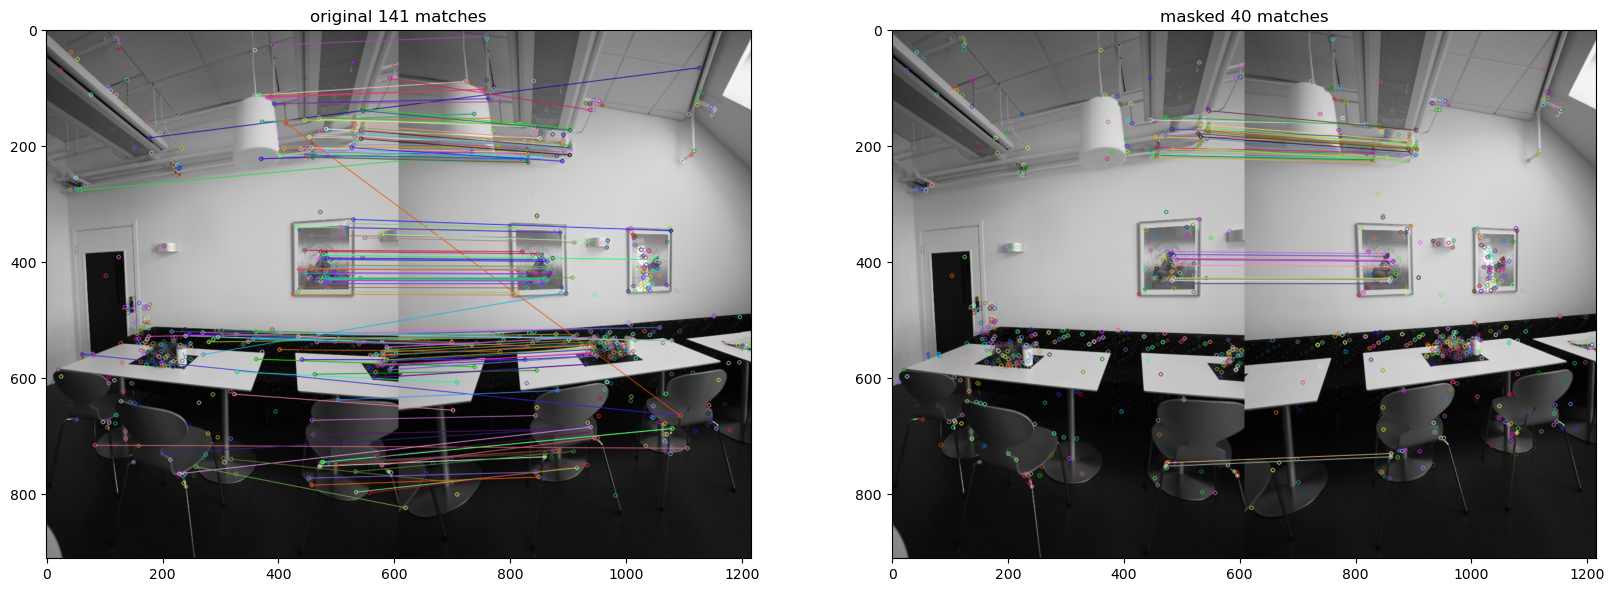

In [49]:
# prune the matches using the mask
good_masked = [good_reciprocal[i] for i in range(len(mask)) if mask[i] == 1]

# show the masked matchings between the two images side by side with the original matchings (good)
# using the cv2.drawMatchesKnn function and the good and good_masked lists
plt.figure(figsize=(20,10))
plt.subplot(121),plt.imshow(cv2.drawMatchesKnn(im1,kpts1,im2,kpts2,good,im1.copy())), plt.title(f'original {len(good_reciprocal)} matches')
plt.subplot(122),plt.imshow(cv2.drawMatchesKnn(im1,kpts1,im2,kpts2,good_masked,im1.copy())), plt.title(f'masked {len(good_masked)} matches');

Very little points. No wonder, the affine transformation is not a good fit for this problem. We need to find a homography

### Homography

Find a homography using unconstrained Linear Least Squares by solving a $AX=0$ equation, and show the resulting homography warping (`cv2.warpPerspective`).

Consider $p_i^{(1)}=(x_i^{(1)},y_i^{(1)})$ and $p_i^{(2)}=(x_i^{(2)},y_i^{(2)})$ our matching points. 

We can formulate the problem as such:
$$
\begin{pmatrix}
h_1 & h_2 & h_3 \\
h_4 & h_5 & h_6 \\
h_7 & h_8 & h_9
\end{pmatrix}
\begin{pmatrix}
x_i^{(1)} \\ y_i^{(1)} \\ 1
\end{pmatrix}
\mathop{=}_{\mathrm{should}}
\lambda
\begin{pmatrix}
x_i^{(2)} \\ y_i^{(2)} \\ 1
\end{pmatrix}
=
\begin{pmatrix}
\lambda x_i^{(2)} \\ \lambda y_i^{(2)} \\ \lambda
\end{pmatrix}
\,\,\,,\,\,\,
\hat{x_i^{(2)}} = x_i^{(2)} / \lambda\,\,\,, \,\,\,
\hat{y_i^{(2)}} = y_i^{(2)} / \lambda
$$
$$
\hat{x_i^{(2)}} = \frac{h_1x_i^{(1)}+h_2y_i^{(1)}+h_3}{h_7x_i^{(1)}+h_8y_i^{(1)}+h_9}
\,\,\,, \,\,\,
\hat{y_i^{(2)}} = \frac{h_4x_i^{(1)}+h_5y_i^{(1)}+h_6}{h_7x_i^{(1)}+h_8y_i^{(1)}+h_9}
$$
$$
h_7\hat{x_i^{(2)}}x_i^{(1)}+h_8\hat{x_i^{(2)}}y_i^{(1)}+h_9\hat{x_i^{(2)}} - h_1x_i^{(1)} - h_2y_i^{(1)} - h_3 = 0\\
h_7\hat{y_i^{(2)}}x_i^{(1)}+h_8\hat{y_i^{(2)}}y_i^{(1)}+h_9\hat{y_i^{(2)}} - h_4x_i^{(1)} - h_5y_i^{(1)} - h_6 = 0
$$
And thus:
$$
\begin{pmatrix}
& \cdots & \\
-x_i^{(1)} & -y_i^{(1)} & -1 & 0 & 0 & 0 & \hat{x_i^{(2)}}x_i^{(1)} & \hat{x_i^{(2)}}y_i^{(1)} & \hat{x_i^{(2)}} \\
0 & 0 & 0 & -x_i^{(1)} & -y_i^{(1)} & -1 & \hat{y_i^{(2)}}x_i^{(1)} & \hat{y_i^{(2)}}y_i^{(1)} & \hat{y_i^{(2)}}  \\
& \cdots & 
\end{pmatrix}
\begin{pmatrix}
h_1 \\ h_2 \\ h_3 \\
h_4 \\ h_5 \\ h_6 \\
h_7 \\ h_8 \\ h_9
\end{pmatrix}
\mathop{=}_{\mathrm{should}}
\begin{pmatrix}
\cdots \\ 0 \\ 0 \\ \cdots 
\end{pmatrix}
$$

In [50]:
# a utility for warping and blending images using a homography matrix
def warpAndblendImagesHomography(image1,image2,H):
    h_,w_ = image1.shape
    im2warp = cv2.warpPerspective(image2, H, (w_,h_), flags=cv2.WARP_INVERSE_MAP, borderMode=cv2.BORDER_CONSTANT)
    im2mask = cv2.warpPerspective(np.ones_like(image2), H, (w_,h_), flags=cv2.WARP_INVERSE_MAP, borderMode=cv2.BORDER_CONSTANT)
    return image1 * (1.0 - im2mask) + im2warp * im2mask


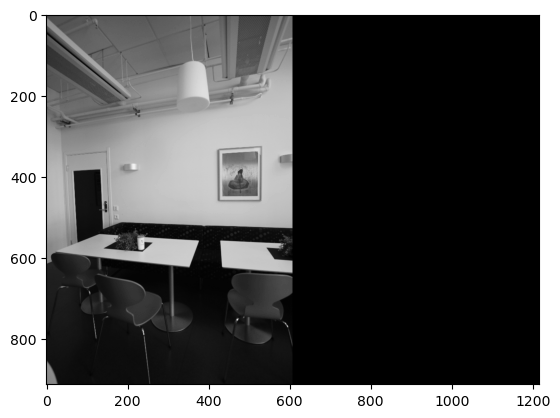

In [51]:
# make a copy of image 1 with room on the right for image 2
im1wide = np.hstack([im1, np.zeros_like(im1)])

# display the im1wide image
plt.imshow(im1wide, cmap='gray')

Implement and Run the LLSQ method for finding homography

In [52]:
# homogeneous linear least squares solution for finding a homography
def findHomographyLLSQ(ptsLeft, ptsRight):
    # create the A matrix, which is a 2n x 9 matrix, where n is the number of points
    A = np.repeat(np.array([[0]*9] * len(ptsLeft), np.float32), 2, axis=0)
    for i in range(len(ptsLeft)):
        # TODO: your code, populate the A matrix
        # hint: use the ptsLeft and ptsRight arrays to get the points, and use the i index to put the points in the correct row
        # e.g. xL,yL = ptsLeft[i] will give you the left point, and xR,yR = ptsRight[i] will give you the right point

        xL,yL = ptsLeft[i]
        xR,yR = ptsRight[i]

        # according to the guidance above, we need to populate the A matrix with the following two rows for each point:
        #  [-xL -yL -1 0 0 0 xR*xL xR*yL xR]
        #  [0 0 0 -xL -yL -1 yR*xL yR*yL yR]
        # the row index can be figured out using the i index
        A[i*2] = np.array([-xL, -yL, -1, 0, 0, 0, xR*xL, xR*yL, xR])
        A[i*2+1] = np.array([0, 0, 0, -xL, -yL, -1, yR*xL, yR*yL, yR])

    # take the SVD of A (`np.linalg.svd`) and pick the last row of Vt (last column of V)
    # TODO: your code here...
    u,z,vt = np.linalg.svd(A)
    # the last row of Vt (e.g. [-1]) is the solution to the homogeneous (Ax=0) linear least squares problem
    # reshape the vector back to a 3,3 matrix
    H = np.reshape(vt[-1], (3,3))
    # normalize the last element to 1 (homogeneous coordinates) by dividing H by the last [2,2] element of H
    return H / H[2,2]

In [53]:
# use the findHomographyLLSQ function you wrote to find the homography matrix
# using the pts1 and pts2 arrays
H = findHomographyLLSQ(pts1,pts2)
print(H)
# get the result using warpAndBlendImagesHomography
lstsqWarp = warpAndblendImagesHomography(im1wide, im2, H)

[[-8.7152761e-01 -1.4693297e-01  3.9205191e+02]
 [-1.3150151e+00 -4.2970818e-01  6.6641156e+02]
 [-2.3409221e-03 -4.2034721e-04  1.0000000e+00]]


Now find a homography using RANSAC (`M, mask = cv2.findHomography`), show only the inliers pair-matches that survived RANSAC as well as the final warping

In [54]:
# use the cv2.findHomography function to find the homography matrix, and use the cv2.RANSAC as the method
H, mask = cv2.findHomography(pts1, pts2, cv2.RANSAC)
print(H)
# use the warpAndblendImagesHomography function to warp and blend the images
findHomogWarp = warpAndblendImagesHomography(im1wide, im2, H)

[[ 2.25288464e+00  6.88030154e-02 -6.20033511e+02]
 [ 8.46456251e-01  1.87469915e+00 -3.59171667e+02]
 [ 2.01151852e-03  3.00462311e-05  1.00000000e+00]]


Display the results

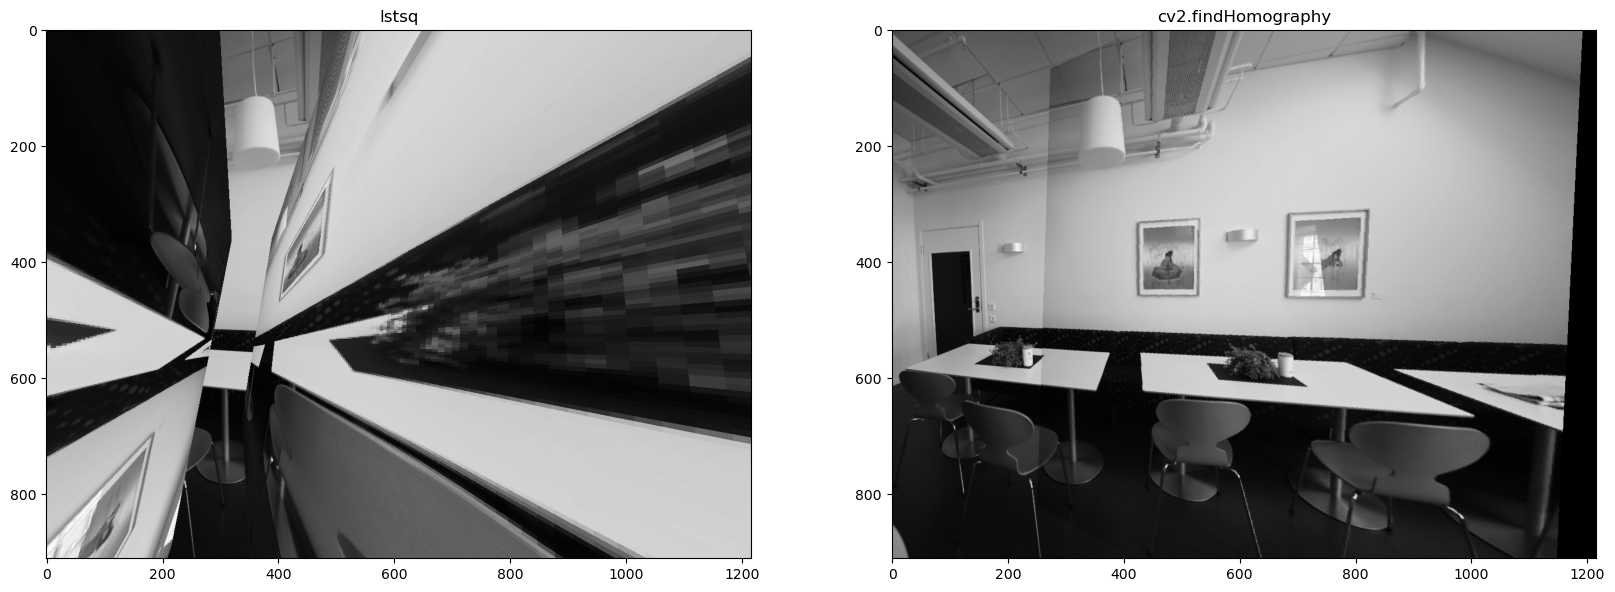

In [55]:
# show the lstsqWarp and findHomogWarp images side by side for comparison
plt.figure(figsize=(20,10))
plt.subplot(121),plt.imshow(lstsqWarp, cmap='gray'), plt.title('lstsq')
plt.subplot(122),plt.imshow(findHomogWarp, cmap='gray'), plt.title('cv2.findHomography');

What was the method that produced the best (valid) image alignment result?

In [56]:
# ? -RANSAC

In a future exercise you will get to implement RANSAC yourself, but for now, you can use OpenCV's implementation.

You were able to align the two images! This is a good result.

## Binary Images

Binary image analysis may seem unimportant, but it is a very powerful tool in computer vision.
Binray images are images that have only two pixel values, 0 and 1. They are used to represent masks, segmentations, and other types of information.
Since we only have two pixel values, we can perform operations on binary images that are much harder with regular images.
A binary image is, after all, a segmentation to 2 classes: the "background" and the "foreground".
With regular natural images it's very hard to obtain a good segmentation, but with binary images it's much easier.

Lets practice some binary image operations

## Getting a binray image from a regular image

Load the image `img1.png` and convert it to a binary image using a threshold of 127 (`cv2.threshold`)
Display the binary image

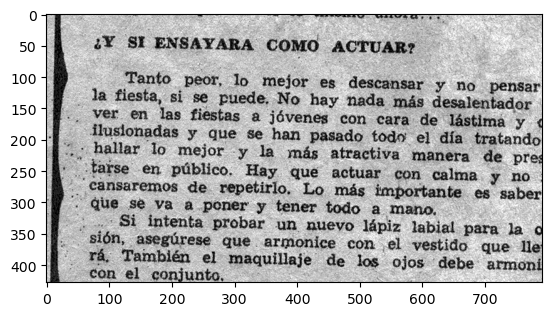

In [57]:
image = cv2.imread("8txbX.png")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')

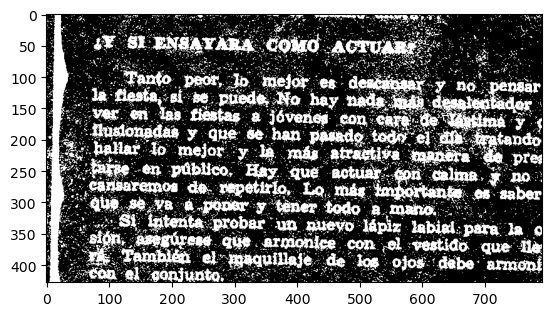

In [58]:
# apply thresholding to the image using cv2.threshold, use cv2.THRESH_BINARY_INV and a threshold of 128
_,thresh = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV)
plt.imshow(thresh, cmap='gray')

We're getting a lot of noise, and the threshold is arbirary. Let's try to use Otsu's method to find the best threshold

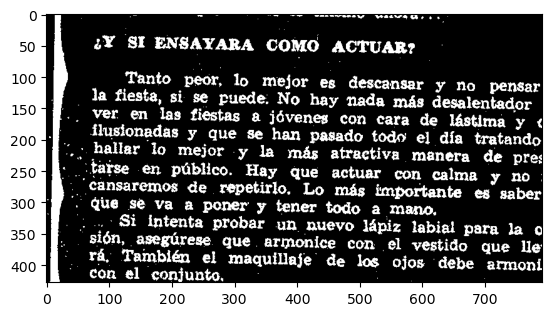

In [59]:
# perform Otsu's thresholding, use cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU
_,thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
plt.imshow(thresh, cmap='gray')

Better, but still some noise. Next try adaptive thresholding which is better for images with non-uniform lighting
Use `blosk_size`=21 and `C`=17 as the parameters for the adaptive thresholding (`cv2.adaptiveThreshold`)

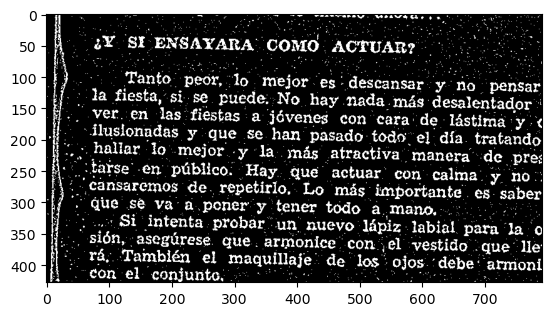

In [60]:
# perform adaptive thresholding usgin cv2.adaptiveThreshold with  cv2.ADAPTIVE_THRESH_GAUSSIAN_C and cv2.THRESH_BINARY_INV
# use the parameters from above
thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 21, 17)
plt.imshow(thresh, cmap='gray')

We get better separation between the characters, which will come in handy for the next steps.
However we're still experiencing some noise. Let's try to use morphological operations to clean up the image

### Morphological Operations

Perform the following operations:
* Erosion: `cv2.erode`
* Dilation: `cv2.dilate`
* Opening: use `cv2.morphologyEx` with `cv2.MORPH_OPEN`
* Closing: use `cv2.morphologyEx` with `cv2.MORPH_CLOSE`
* Hit-and-Miss: use `cv2.morphologyEx` with `cv2.MORPH_HITMISS`

(<Axes: title={'center': 'original'}>,
 Text(0.5, 1.0, 'original'))

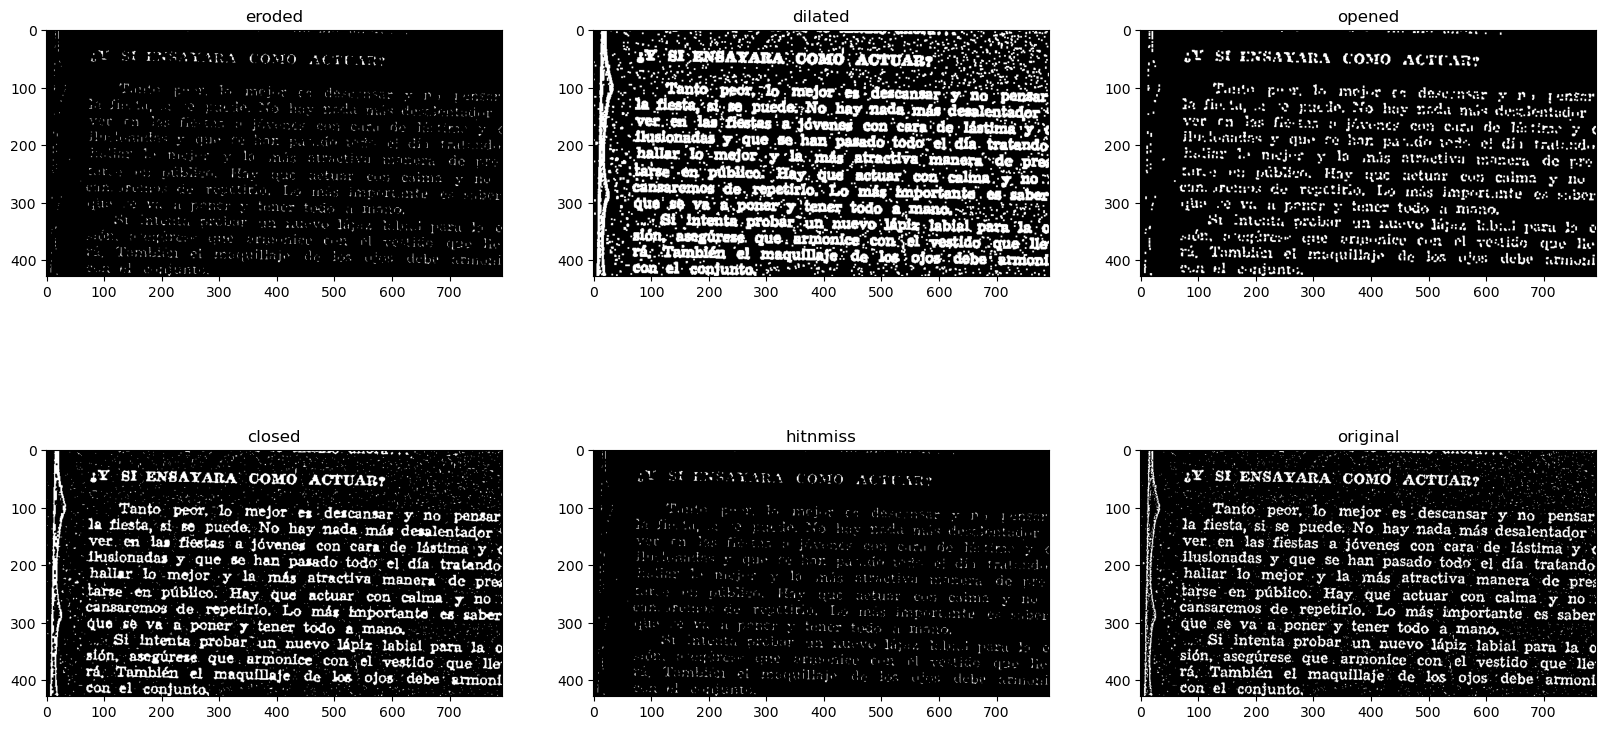

In [61]:
eroded = cv2.erode(thresh, np.ones((3,3), np.uint8), iterations=1)
dilated = cv2.dilate(thresh, np.ones((3,3), np.uint8), iterations=1)
opened = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, np.ones((3,3), np.uint8))
closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, np.ones((3,3), np.uint8))
hitnmiss = cv2.morphologyEx(thresh, cv2.MORPH_HITMISS, np.ones((3,3)))
plt.figure(figsize=(20,10))
plt.subplot(231),plt.imshow(eroded, cmap='gray'), plt.title('eroded')
plt.subplot(232),plt.imshow(dilated, cmap='gray'), plt.title('dilated')
plt.subplot(233),plt.imshow(opened, cmap='gray'), plt.title('opened')
plt.subplot(234),plt.imshow(closed, cmap='gray'), plt.title('closed')
plt.subplot(235),plt.imshow(hitnmiss, cmap='gray'), plt.title('hitnmiss')
plt.subplot(236),plt.imshow(thresh, cmap='gray'), plt.title('original')

It looks like with such a delicate image, the morphological operations are not very effective. Let's try to use the contours to clean up the image

### Contour Detection

On the binary image find the contours (`cv2.findContours`) and display them (`cv2.drawContours`)

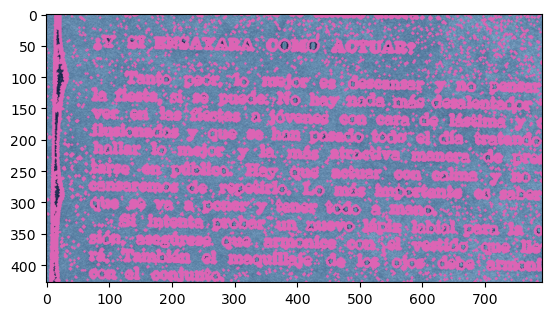

In [62]:
# finc contours in the image
# use cv2.findContours with cv2.RETR_EXTERNAL (to get only the external contours) and cv2.CHAIN_APPROX_SIMPLE
cnts, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

output = image.copy()
# draw contours on the image using cv2.drawContours, give the function the contours, -1 to draw all of them, and a nice color
cv2.drawContours(output, cnts, -1, (220, 100, 180), 3)
plt.imshow(output)

We picked up a lot of noise. Let's try to filter the contours by area and only keep the big ones

Contour cleanup and bounding box
* Filter out small contours based on their area (`cv2.contourArea`)
* use two threshold values: a lower and an upper bound. come up with the values yourself
* Draw the bounding box of the remaining contours (`cv2.boundingRect` and `cv2.rectangle`)

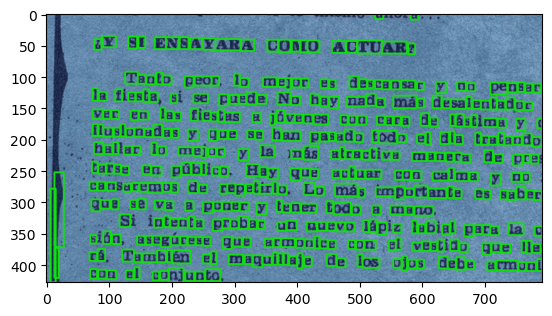

In [63]:
# loop over the contours and filter out small ones
count = 0

output = image.copy()
for c in cnts:
    # compute the area of the contour with cv2.contourArea
    area = cv2.contourArea(c)
    # threshold the area
    if area < 40 or area > 300:
        count += 1
        continue
    # compute the bounding box for the contour with cv2.boundingRect
    (x, y, w, h) = cv2.boundingRect(c)
    # draw the bounding box on the image with cv2.rectangle
    cv2.rectangle(output, (x,y), (x+w, y+h), (20, 220, 20), 2)
plt.imshow(output)

How did you pick the threshold?

A major problem is picking the threshold for the contour accepting area.

Let's try a non-paramteric method. 

Plot a histogram of all the sizes of the contours and let's try to pick a threshold based on the plot. Use `plt.hist`

Filter out in the first place all the contours that are < 10 pixels in area. Those are definitely noise.

(array([ 46., 178., 112.,  58.,  56.,   7.,   6.,   5.,   6.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([  10.5 ,   39.38,   68.26,   97.14,  126.02,  154.9 ,  183.78,
         212.66,  241.54,  270.42,  299.3 ,  328.18,  357.06,  385.94,
         414.82,  443.7 ,  472.58,  501.46,  530.34,  559.22,  588.1 ,
         616.98,  645.86,  674.74,  703.62,  732.5 ,  761.38,  790.26,
         819.14,  848.02,  876.9 ,  905.78,  934.66,  963.54,  992.42,
        1021.3 , 1050.18, 1079.06, 1107.94, 1136.82, 1165.7 , 1194.58,
        1223.46, 1252.34, 1281.22, 1310.1 , 1338.98, 1367.86, 1396.74,
        1425.62, 1454.5 ]),
 <BarContainer object of 50 artists>)

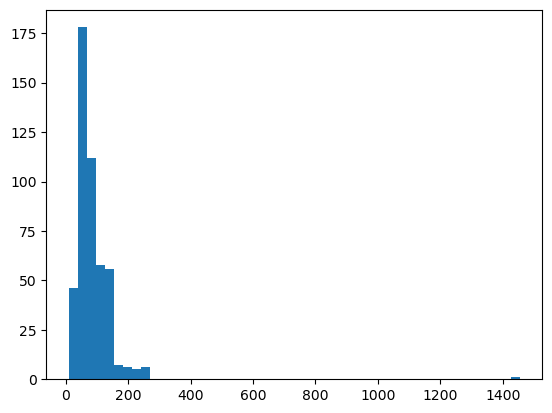

In [64]:
# plot a histogram of all the contour sizes
# first get all the sizes in a list. fiter out the ones that are way too small (e.g. < 10)
sizes = [cv2.contourArea(c) for c in cnts if cv2.contourArea(c) > 10]
# then plot the histogram using plt.hist
plt.hist(sizes, bins=50)

We can see in the plot that there is a peak where most countors are of the same size. Let's try to use this as a threshold.

Since this is a distribution function, we can fit a gaussian to it and pick the mean as the threshold as well as have a measure of the variance of the contour sizes.
To calculate the mean and variance of the contour sizes, use `scipy.stats.norm.fit`

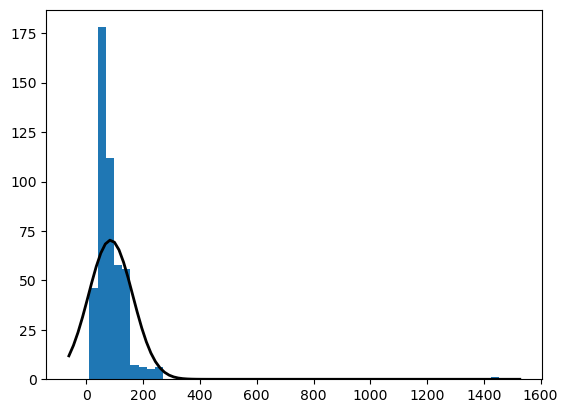

In [65]:
from scipy.stats import norm
# fit a normal distribution to the data, use `norm.fit` and grab e.g. `mu` and `std`
mu, std = norm.fit(sizes)
# plot the histogram with plt.hist. I used 50 bins
counts, bins, patches = plt.hist(sizes, bins=50)
# plot the PDF
# use the mean (e.g. `mu`) and standard deviation (e.g. `std`) from the fit to plot the normal distribution
# use np.linspace to create a range of x values (you can take this from the data),
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
# and use norm.pdf to get the y values
p = norm.pdf(x, mu, std) * len(sizes) * (bins[1]-bins[0])
# finally, use plt.plot to plot the normal distribution *on top* of the histogram
plt.plot(x, p, 'k', linewidth=2)

OK Now we have a good idea of where our threshold should be. Let's use it to filter out the contours

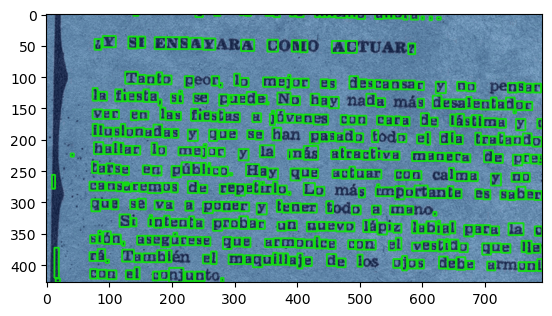

In [66]:
output = image.copy()
# use mu and std to filter out contours that are not within 1 standard deviation from the mean
# you can get this with list comprehension, e.g. [c for c in cnts if ...]
filtered_contours = [c for c in cnts if abs(cv2.contourArea(c) - mu) < std]
for c in filtered_contours:
    # compute the bounding box for the contour
    (x, y, w, h) = cv2.boundingRect(c)
    # draw the bounding box on the image
    cv2.rectangle(output, (x, y), (x+w, y+h), (20, 220, 20), 2)
    
plt.imshow(output)

We still have some contours that are not charaters, but at least we got rid of most of the noise.

### Optical Character Recognition (OCR)

OCR is a very powerful tool in computer vision, and it's very easy to use with binary images.

The goal in OCR is to detect characters in an image and then recognize them, turning the image into text.

Let's attempt a simple OCR task.

From the contours detected in the previous step, crop the bounding box of each contour and display it.

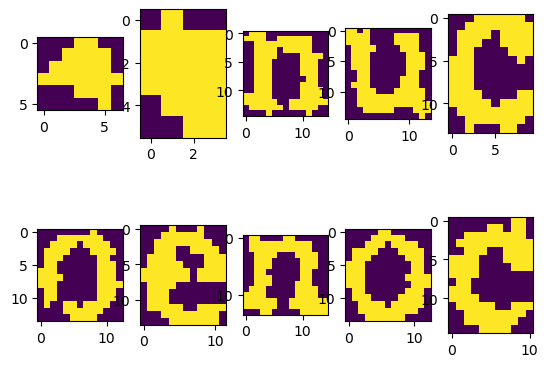

In [67]:
# take the first 10 contours and draw them individually as image patches (crops)
# create a list of the bounding boxes (cv2.boundingRect) for the first 10 contours (e.g. filtered_contours[:10])
contour_rects = [cv2.boundingRect(c) for c in filtered_contours[:10]]
for i,c in enumerate(contour_rects):
    # plot the individual contours using plt.subplot(2,5,i+1)
    # cut out thresh[y:y+h, x:x+w] and use plt.imshow to plot the contour
    plt.subplot(2,5,i+1)
    plt.imshow(thresh[c[1]:c[1]+c[3], c[0]:c[0]+c[2]])

Before we continue we must normalize the images to a standard size. Resize the cropped images to 16x16 (`cv2.resize`)

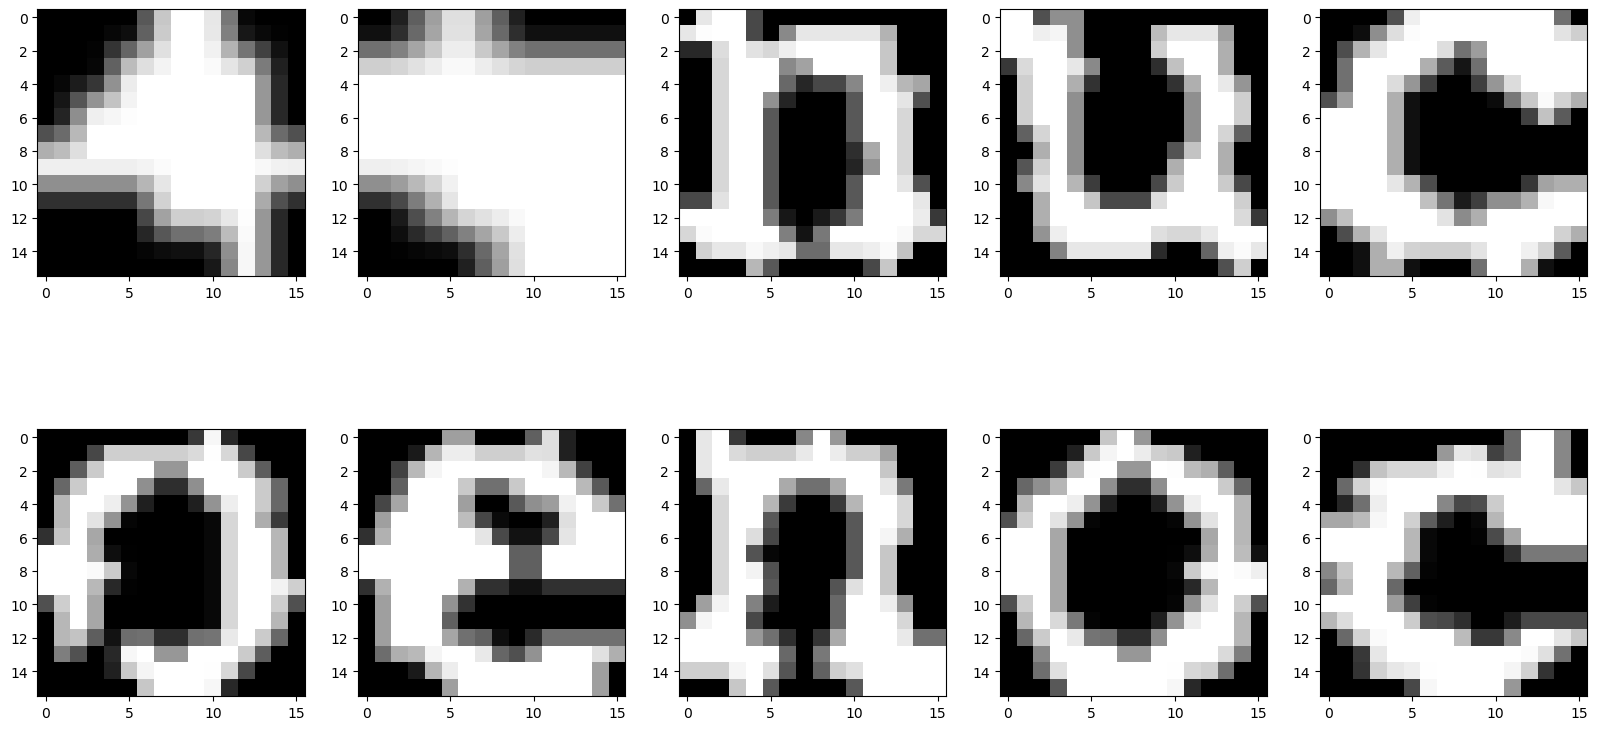

In [68]:
# create a list with the image patches (e.g. thresh[y:y+h, x:x+w]) for our 10 contours
patches = [thresh[c[1]:c[1]+c[3], c[0]:c[0]+c[2]] for c in contour_rects]
# resize the patches to 16x16 with cv2.resize
patches = [cv2.resize(p, (16,16)) for p in patches]

# plot the patches
plt.figure(figsize=(20,10))
for i,p in enumerate(patches):
    # use plt.subplot(2,5,i+1) to plot the patches
    plt.subplot(2,5, i+1)
    plt.imshow(p, cmap='gray')

We're going to use a few examples as character templates, and we're going to compare the cropped images to the templates to see if we can recognize the characters.

For the first 10 contours above, build a "dictionary" of the characters in the small patch and assign a character.

In [69]:
# create a list with the assigned labels
labels = [
    # for me it was: "?", "?", "n", "u", "c", "o", "e", "n", "o", "c",
    # but it may be different for you
    "?", "?", "n", "u", "c", "o", "e", "n", "o", "c"
]

Now that we have a dictionary, let's see if we can recognize the rest of the characters in the image.
Obviously we will be limited to just the characters in the dictionary we made.

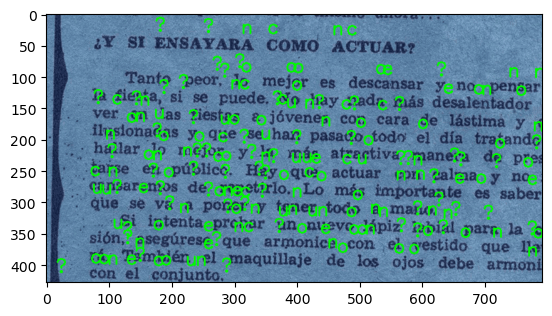

In [70]:
# scan all the filtered contours in the image
# get their bounding boxes and crop a patche with the box
# resize the new patch to 16x16
# and compare the patch to our dictionary of letters using a simple euclidean distance
# find the bestmatch using `np.argmin` and `cv2.putText` the label of the best match on the image
# set a threshold for the minimum distance (e.g. `np.min(distances)`) otherwise we will get wrong results,
# my threshold was 1800.
output = image.copy()
for i,c in enumerate(filtered_contours):
    # get the bounding box for the contour c
    (x, y, w, h) = cv2.boundingRect(c)
    # resize the patch (e.g. thresh[y:y+h, x:x+w]) to 16x16
    patch = cv2.resize(thresh[y:y+h, x:x+w], (16,16))
    # calculate the euclidean distance between the patch and all the patches in the dictionary
    # use np.linalg.norm(patch - p) for every p in patches. list comprehension is useful here
    distances = [np.linalg.norm(patch - p) for p in patches]
    # set a threshold for the minimum distance otherwise we will get wrong results
    if np.min(distances) > 1800:
        continue
    # find the index of the minimum distance
    idx = np.argmin(distances)
    # print the label of the minimum distance
    # draw the letter on the image
    # use cv2.putText to draw the label on the image
    cv2.putText(output, labels[idx], (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 250, 0), 2)    
plt.imshow(output)

We were able to read much of the letters in our dictionary, but we missed a few. This is a very simple OCR task, and it's very limited in scope, but it's a good start.

You may want to expand your dictionary to include more characters, and you may want to use a more advanced method to compare the characters to the templates.

That's a wrap!